# Banana Navigation Project
___

This is my first attempt at creating a Deep Q-Network in Python with PyTorch.

Please refer to the README.md file for details.


So to begin with, I

## Load the necessary packages

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
from collections import deque
import numpy as np
import gym
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

## Instantiate the Environment and the Agent

The definition of the Agent is provided in the Python file "dqn_agent.py".  This file must reside in the same folder as this Jypeter Notebook (the "Banana_Navigation_Project.ipynb" file).  I need to load that file in for use.

I am using an Environment provided by (Unity)[https://unity.com/].  The Environment that I am using is called ***Banana***.

In [3]:
from dqn_agent import Agent
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


I grab the first ***brain*** that the Environment makes available and define it as "brain".

In [4]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

Now I reset the Environment to a known good state and will pull some important parameters (that I'll need later) from the Environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
state_size = len(state)
print('State Size = ', state_size)
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

State Size =  37
Number of actions: 4


And, finally, I set up my Agent with the data I gathered above.

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

## Train the Agent with the Deep Q-Network

In [7]:
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, train_mode=True): 
    
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train_mode(bool): if 'True' set environment to training mode
    """

    scores = []                                                 # list containing scores from each episode
    mov_avg = []                                                # list containing the moving averages
    mean_scores = []
    mean_score = 0.0
    solved = False
    scores_window = deque(maxlen=100)                           # last 100 scores
    eps = eps_start                                             # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
        state = env_info.vector_observations[0]                 # get the current state
        score = 0  
        
        if train_mode:
            for t in range(max_t):
                action = agent.act(state, eps)                      # get an action
                env_info = env.step(action)[brain_name]             # send the action to the environment
                next_state = env_info.vector_observations[0]        # get the next state
                reward = env_info.rewards[0]                        # get the reward
                done = env_info.local_done[0]                       # see if episode has finished
                agent.step(state, action, reward, next_state, done) # this is the learning step
                score += reward                                     # update the score
                state = next_state                                  # roll over the state to next time step         
                if done:
                    break
   
            scores_window.append(score)                             # save most recent score
            if solved==False:
                scores.append(score)                                # save most recent score to the total
            average = np.mean(scores_window)                        # calculate the average
            if solved==False:
                mov_avg.append(average)                             # save the most recent moving average
            eps = max(eps_end, eps_decay*eps)                       # decrease epsilon a little
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
            if i_episode % 100 == 0:
                print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            if (np.mean(scores_window) >= 13.0) & (solved==False):
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                      .format(i_episode, np.mean(scores_window)))
                solved = True
            if (np.mean(scores_window) >= 15.0) & (solved==True):
                print('\nEnvironment solved with BUFFER in {:d} episodes!\tAverage Score: {:.2f}'
                      .format(i_episode, np.mean(scores_window)))           # to ensure that my final plot stays > 13
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth') # save the weights of the trained agent
                break  
                
        if not train_mode:
            while True:
                action = agent.act(state, eps=0)                    # get an action
                env_info = env.step(action)[brain_name]             # send the action to the environment
                next_state = env_info.vector_observations[0]        # get the next state
                reward = env_info.rewards[0]                        # get the reward
                done = env_info.local_done[0]                       # see if episode has finished
                score += reward                                     # update the score
                state = next_state                                  # roll over the state to next time step             
                if done:
                    scores.append(score)
                    mean_score = np.mean(scores)
                    mean_scores.append(mean_score)
                    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
                    break
        
    return scores, mov_avg, mean_scores

## I Run the Training Loop 

In [8]:
scores, mov_avg, _ = dqn(n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, train_mode=True)

Episode 100	Average Score: 1.00
Episode 200	Average Score: 4.52
Episode 300	Average Score: 8.26
Episode 400	Average Score: 9.80
Episode 500	Average Score: 11.98
Episode 572	Average Score: 13.00
Environment solved in 572 episodes!	Average Score: 13.00
Episode 600	Average Score: 13.07
Episode 700	Average Score: 14.77
Episode 740	Average Score: 15.01
Environment solved with BUFFER in 740 episodes!	Average Score: 15.01


## And I Plot the Outcomes

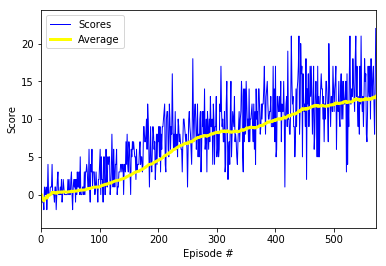

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, c='blue', linewidth=1, label="Scores")
plt.plot(np.arange(len(scores)), mov_avg, c='yellow', linewidth=3, label="Average")
plt.legend(loc='upper left')
plt.margins(x=0.0, y=0.1)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Now I go ahead and run the trained Agent

Recover the Weights from Trained Agent

In [10]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

Run the Trained Agent in the Environment

In [11]:
number_of_games = 15
_, _, mean_scores = dqn(n_episodes=(number_of_games + 1), train_mode=False)

Episode 1	Average Score: 21.00
Episode 2	Average Score: 20.00
Episode 3	Average Score: 17.67
Episode 4	Average Score: 16.00
Episode 5	Average Score: 16.00
Episode 6	Average Score: 16.83
Episode 7	Average Score: 17.00
Episode 8	Average Score: 16.12
Episode 9	Average Score: 16.78
Episode 10	Average Score: 15.50
Episode 11	Average Score: 15.45
Episode 12	Average Score: 15.75
Episode 13	Average Score: 15.77
Episode 14	Average Score: 15.36
Episode 15	Average Score: 15.40
Episode 16	Average Score: 15.19


Because I'm in the Udacity Workspace, I'm unable to actually see the play.
So, I'll plot the scores over a span of fifteen games.

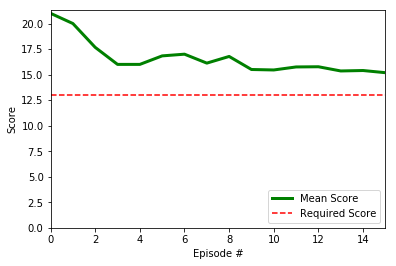

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_scores)), mean_scores, c='green', linewidth=3, label="Mean Score")
plt.ylim(bottom=0)
plt.axhline(y=13, c='red', linestyle='--', label="Required Score")
plt.legend(loc='lower right')
plt.margins(x=0.0, y=1.0)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, I close the Environment

In [13]:
env.close()